## 0. Logistics

### Imports

In [22]:
import csv
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from collections import Counter
np.random.seed(42)
import matplotlib.pyplot as plt



### Data

In [5]:
# Download data from https://archive.ics.uci.edu/ml/datasets/spambase
FILE_NAME = "spambase.data"

# URL to fetch the data from
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"

# 1) Fetch data directly from the URL
response = requests.get(DATA_URL)
data_content = response.text

# 2) Load the fetched data using CSV reader
data_reader = csv.reader(StringIO(data_content), delimiter=",")
data = np.array(list(data_reader), dtype=np.float32)

print(data.shape)

(4601, 58)


## 1. Linear Regression   

### Code from Scratch

In [14]:
def r2_score(y_true, y_pred):
    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0, 1]
    return corr ** 2


class LinearRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias
            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_approximated = np.dot(X, self.weights) + self.bias
        return y_approximated

### Testing Linear Regression

MSE: 305.7719958301902
Accuracy: 0.9253717934621964


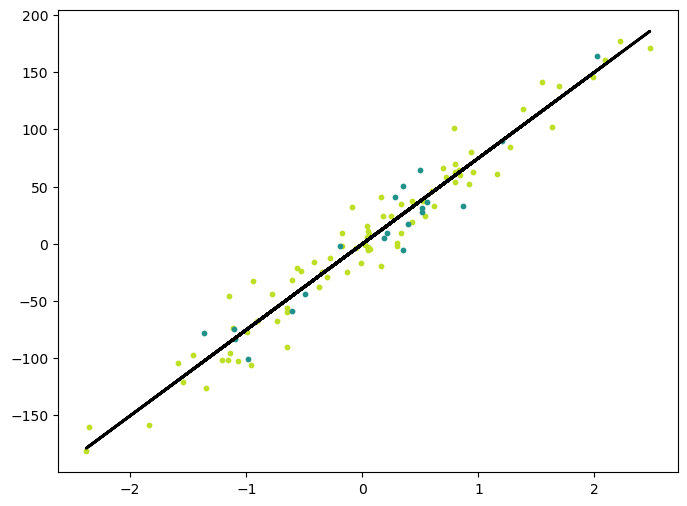

In [11]:
# Testing
if __name__ == "__main__":
    # Imports

    def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    X, y = datasets.make_regression(
        n_samples=100, n_features=1, noise=20, random_state=4
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    regressor = LinearRegression(learning_rate=0.01, n_iters=1000)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    accu = r2_score(y_test, predictions)
    print("Accuracy:", accu)

    y_pred_line = regressor.predict(X)
    cmap = plt.get_cmap("viridis")
    fig = plt.figure(figsize=(8, 6))
    m1 = plt.scatter(X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(X, y_pred_line, color="black", linewidth=2, label="Prediction")
    plt.show()

### Implementation with Sklearn

## 2. Logistic Regression   

### Code from Scratch

In [12]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self._sigmoid(linear_model)

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))



### Testing Logistic Regression

In [13]:
if __name__ == "__main__":

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    bc = datasets.load_breast_cancer()
    X, y = bc.data, bc.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    regressor = LogisticRegression(learning_rate=0.0001, n_iters=1000)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

    print("LR classification accuracy:", accuracy(y_test, predictions))

LR classification accuracy: 0.9298245614035088


## 3. Naive Bayes

### Code from Scratch

In [17]:
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

### Testing Naive Bayes

In [18]:
# Testing
if __name__ == "__main__":
    # Imports
    from sklearn.model_selection import train_test_split
    from sklearn import datasets

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    X, y = datasets.make_classification(
        n_samples=1000, n_features=10, n_classes=2, random_state=123
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )

    nb = NaiveBayes()
    nb.fit(X_train, y_train)
    predictions = nb.predict(X_test)

    print("Naive Bayes classification accuracy", accuracy(y_test, predictions))

Naive Bayes classification accuracy 0.965


## 4. K-Nearest Neighbors

### Code from Scratch

In [20]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[: self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # return the most common class label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]


### Testing K-Nearest Neighbors

In [21]:
if __name__ == "__main__":
    # Imports
    from matplotlib.colors import ListedColormap
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    cmap = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    iris = datasets.load_iris()
    X, y = iris.data, iris.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    k = 3
    clf = KNN(k=k)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("KNN classification accuracy", accuracy(y_test, predictions))

KNN classification accuracy 1.0


## 5. K-Means Clustering

### Code from Scratch

In [23]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMeans:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

### Testing K-Means Clustering

(500, 2)
3


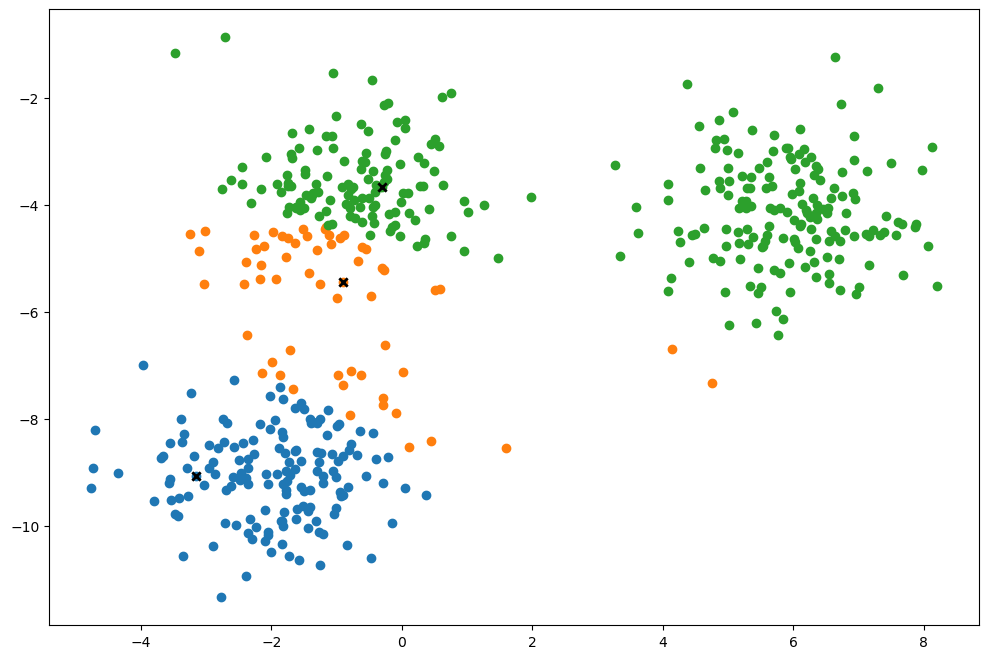

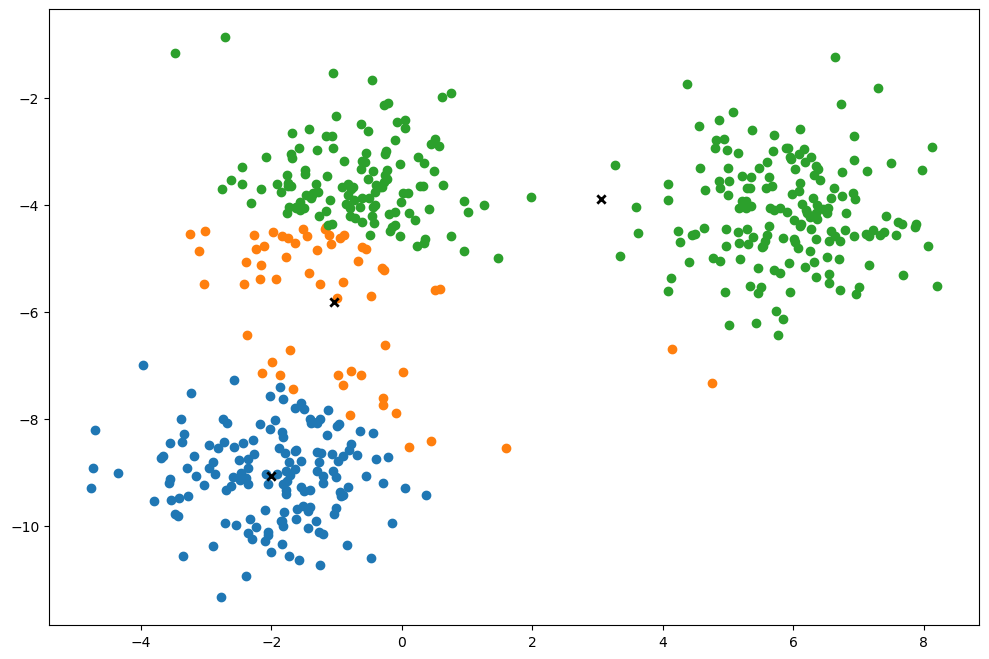

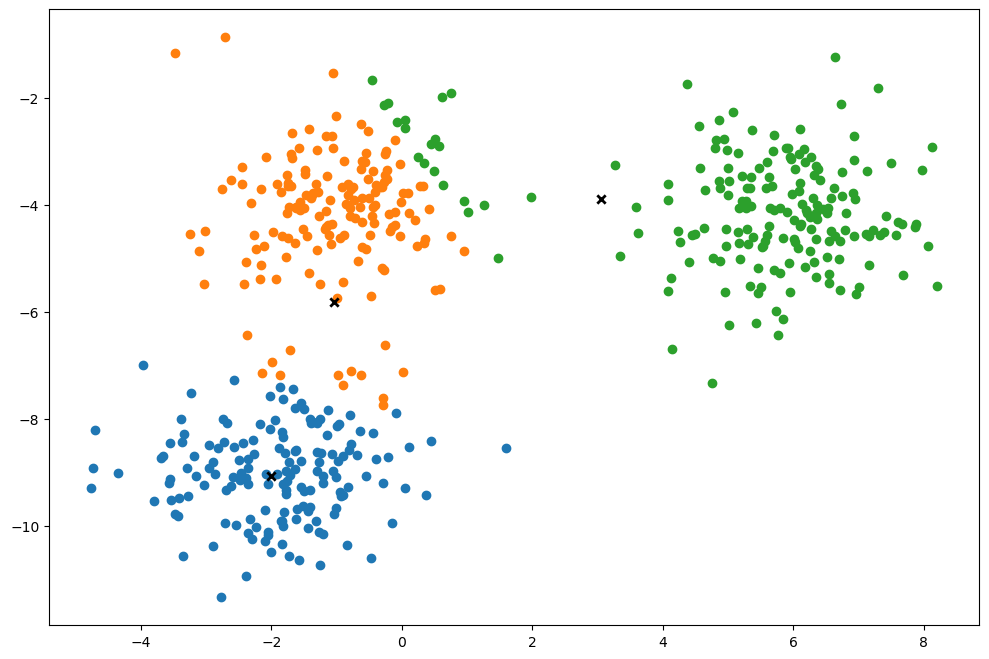

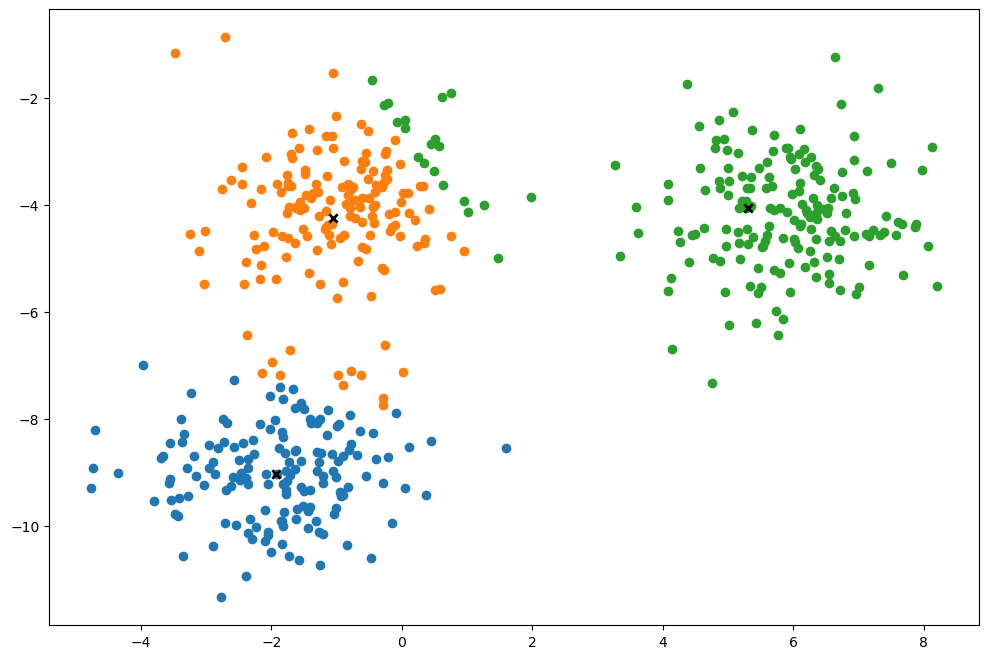

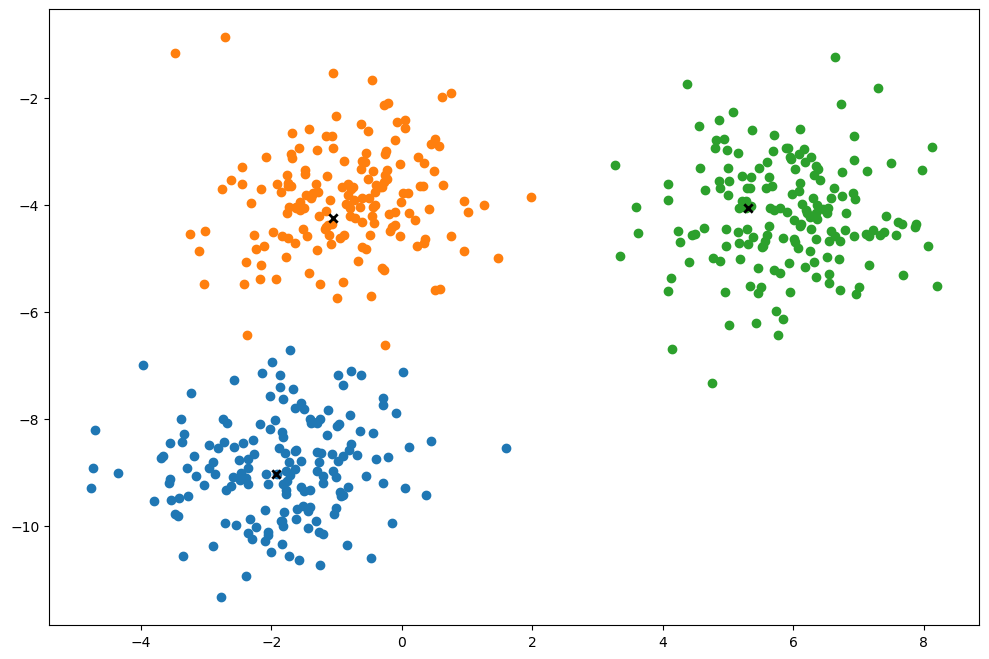

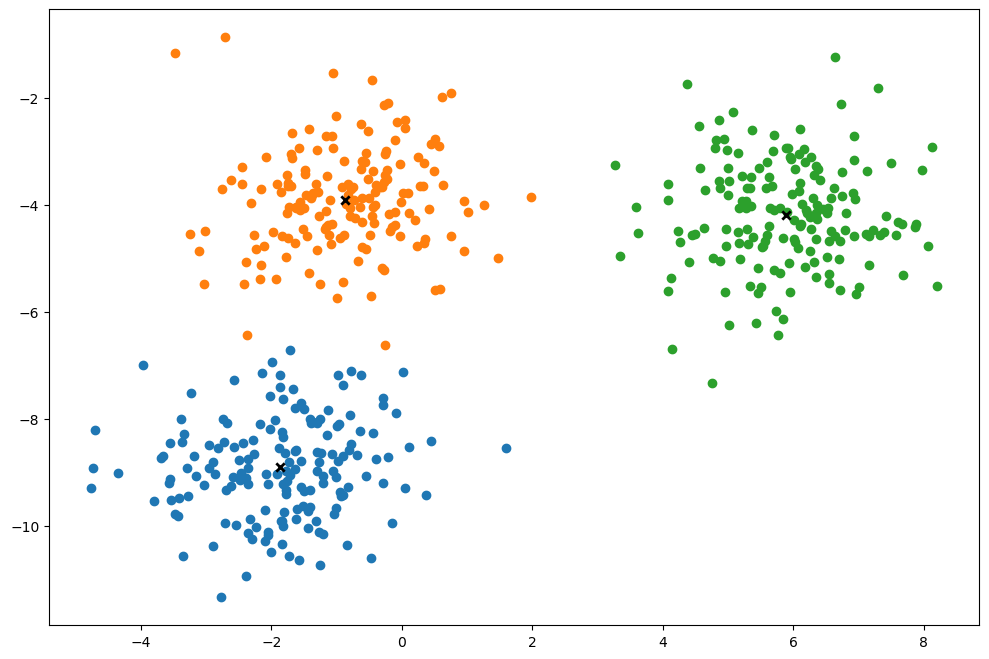

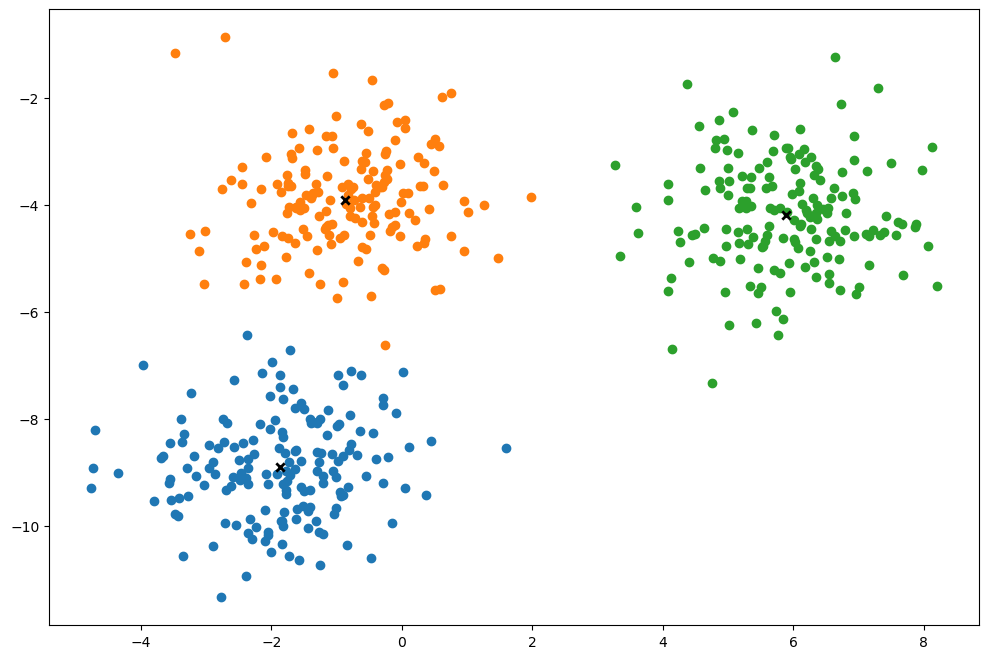

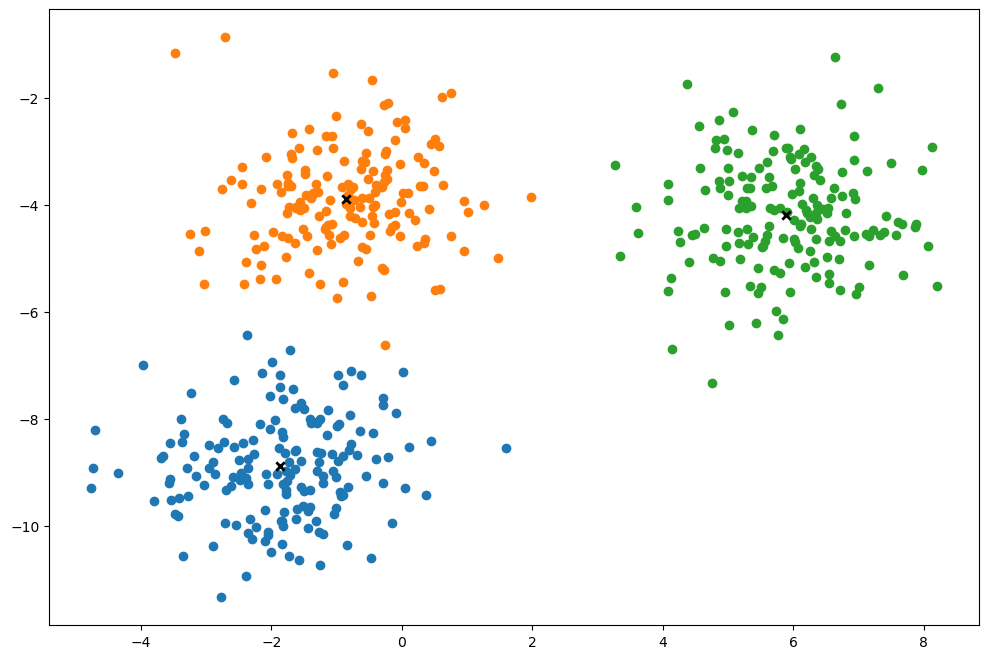

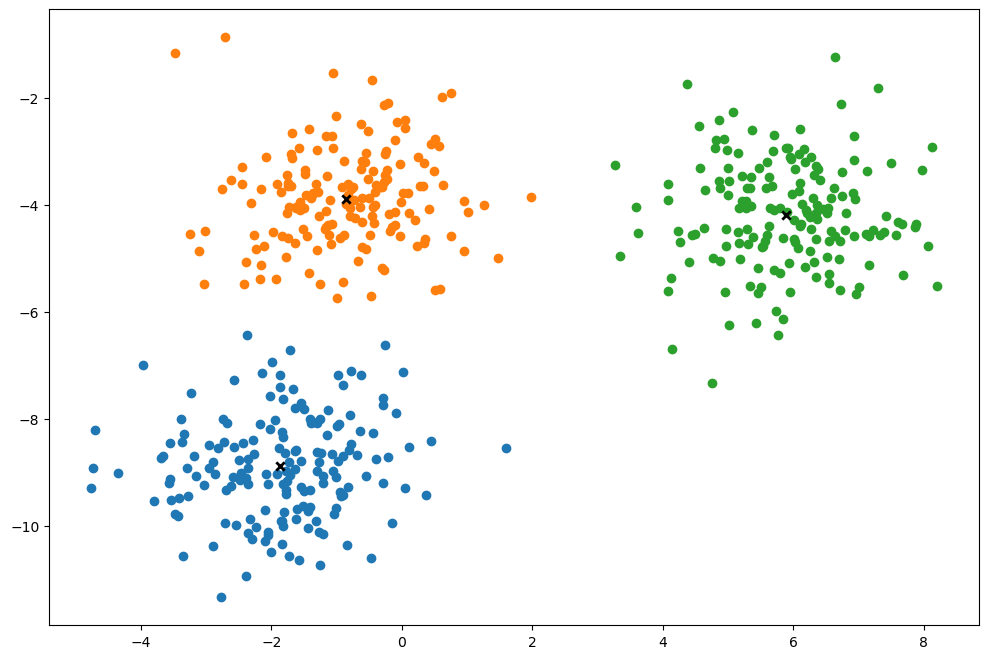

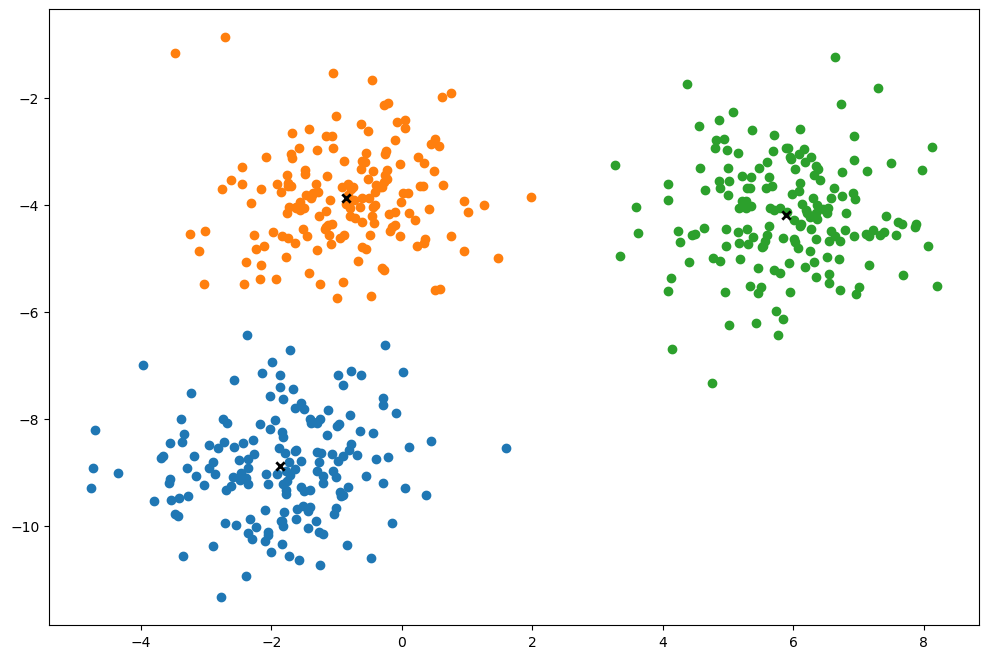

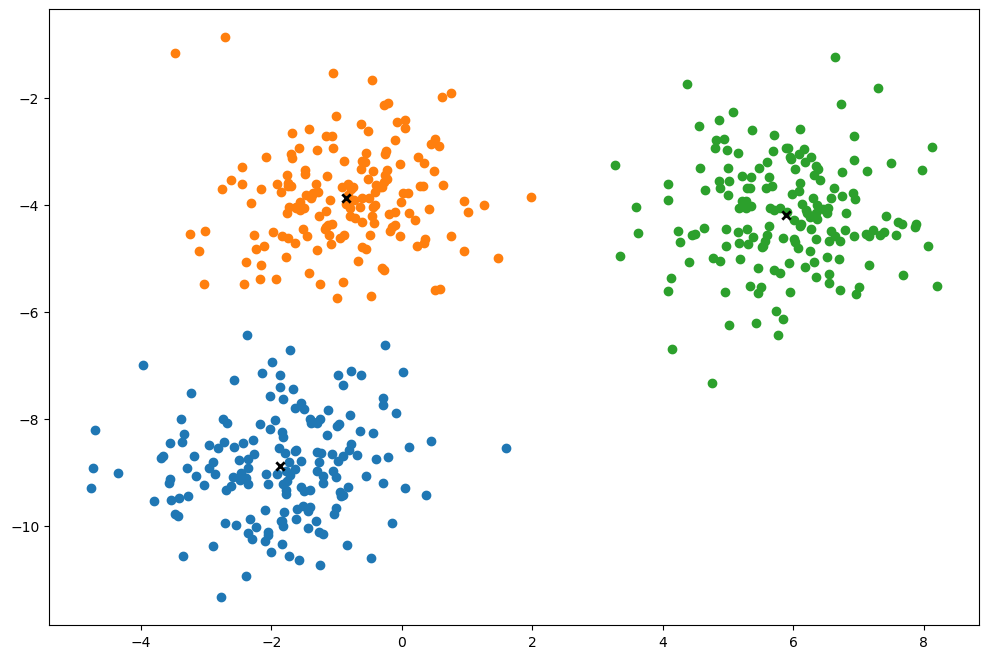

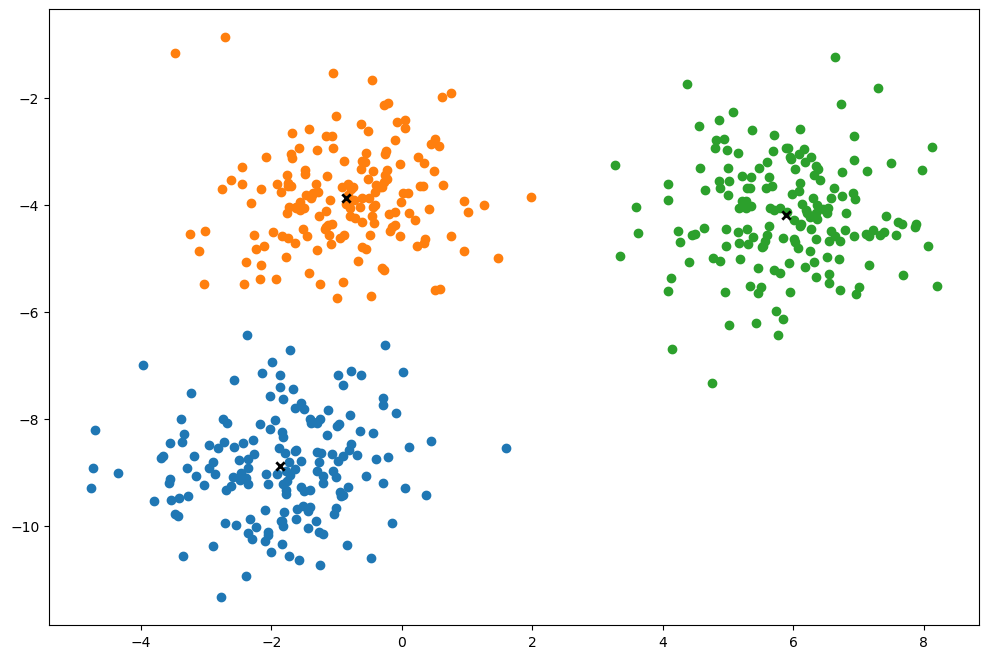

In [24]:
# Testing
if __name__ == "__main__":
    from sklearn.datasets import make_blobs

    X, y = make_blobs(
        centers=3, n_samples=500, n_features=2, shuffle=True, random_state=40
    )
    print(X.shape)

    clusters = len(np.unique(y))
    print(clusters)

    k = KMeans(K=clusters, max_iters=150, plot_steps=True)
    y_pred = k.predict(X)

    k.plot()

## 6. Principal Component Analysis (PCA)

### Code from Scratch

In [25]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)


### Testing Principal Component Analysis (PCA)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


/var/folders/5d/chn1j4p16gb99snr1ns8vph80000gn/T/ipykernel_42305/3985628446.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)


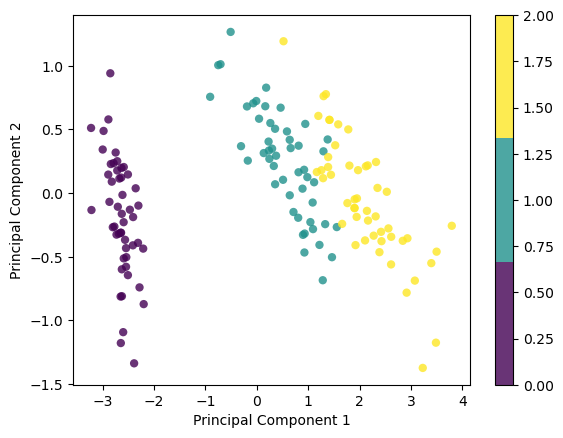

In [26]:
# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

    # data = datasets.load_digits()
    data = datasets.load_iris()
    X = data.data
    y = data.target

    # Project the data onto the 2 primary principal components
    pca = PCA(2)
    pca.fit(X)
    X_projected = pca.transform(X)

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1 = X_projected[:, 0]
    x2 = X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar()
    plt.show()

## 7. Linear Discriminant Analysis (LDA)

### Code from Scratch

In [27]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)

### Testing Linear Discriminant Analysis (LDA)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


/var/folders/5d/chn1j4p16gb99snr1ns8vph80000gn/T/ipykernel_42305/774800323.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)


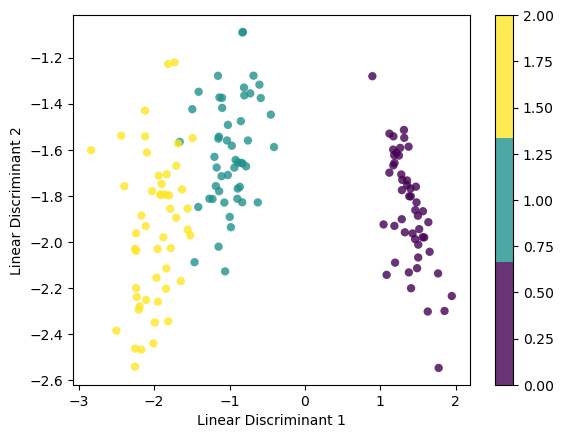

In [28]:
# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

    data = datasets.load_iris()
    X, y = data.data, data.target

    # Project the data onto the 2 primary linear discriminants
    lda = LDA(2)
    lda.fit(X, y)
    X_projected = lda.transform(X)

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1, x2 = X_projected[:, 0], X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
    )

    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.colorbar()
    plt.show()

## 8. Decision Tree

### Code from Scratch

In [29]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

### Testing Decision Tree

In [30]:
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    clf = DecisionTree(max_depth=10)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)

    print("Accuracy:", acc)

Accuracy: 0.9210526315789473


## 9. Random Forest

### Code from Scratch

In [33]:
import DecisionTree


def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

ModuleNotFoundError: No module named 'DecisionTree'

### Testing Random Forest

In [ ]:
# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X = data.data
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    clf = RandomForest(n_trees=3, max_depth=10)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)

    print("Accuracy:", acc)

LR classification accuracy: 0.9298245614035088


## 10. Adaboost

### Code from Scratch

In [34]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []

        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

### Testing Adaboost

In [35]:
# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    y[y == 0] = -1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5
    )

    # Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy(y_test, y_pred)
    print("Accuracy:", acc)

Accuracy: 0.9736842105263158


## 11. Support Vector Machines (SVM)

### Code from Scratch

In [36]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

### Testing SVM

[0.58977016 0.17946483] -0.1520000000000001


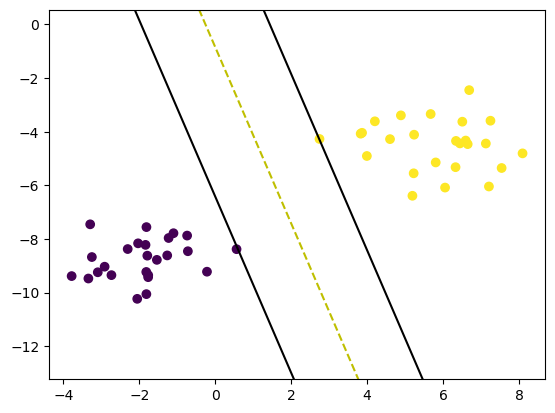

In [37]:
# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    import matplotlib.pyplot as plt

    X, y = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
    y = np.where(y == 0, -1, 1)

    clf = SVM()
    clf.fit(X, y)
    # predictions = clf.predict(X)

    print(clf.w, clf.b)

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

        x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

    visualize_svm()

## 12. Perceptron

### Code from Scratch

In [38]:
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation_func = self._unit_step_func
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        y_ = np.array([1 if i > 0 else 0 for i in y])

        for _ in range(self.n_iters):

            for idx, x_i in enumerate(X):

                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation_func(linear_output)

                # Perceptron update rule
                update = self.lr * (y_[idx] - y_predicted)

                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activation_func(linear_output)
        return y_predicted

    def _unit_step_func(self, x):
        return np.where(x >= 0, 1, 0)

### Testing Perceptron

Perceptron classification accuracy 1.0


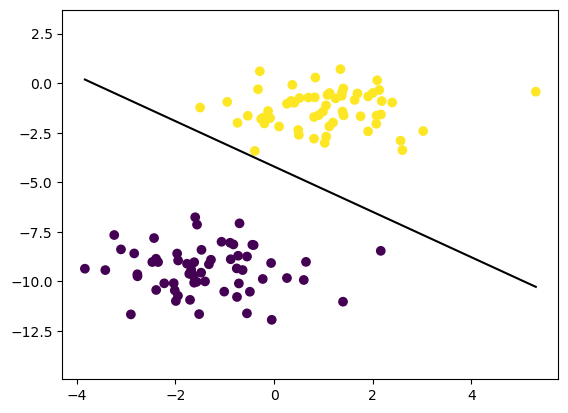

In [39]:
# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn import datasets

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    X, y = datasets.make_blobs(
        n_samples=150, n_features=2, centers=2, cluster_std=1.05, random_state=2
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )

    p = Perceptron(learning_rate=0.01, n_iters=1000)
    p.fit(X_train, y_train)
    predictions = p.predict(X_test)

    print("Perceptron classification accuracy", accuracy(y_test, predictions))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train)

    x0_1 = np.amin(X_train[:, 0])
    x0_2 = np.amax(X_train[:, 0])

    x1_1 = (-p.weights[0] * x0_1 - p.bias) / p.weights[1]
    x1_2 = (-p.weights[0] * x0_2 - p.bias) / p.weights[1]

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "k")

    ymin = np.amin(X_train[:, 1])
    ymax = np.amax(X_train[:, 1])
    ax.set_ylim([ymin - 3, ymax + 3])

    plt.show()